# Anomaly Detection - Isolation Forests

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
from sklearn.ensemble import IsolationForest

import seaborn
from scipy.spatial.distance import pdist, squareform

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
dataset = pd.read_csv('../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})

#TODO: remove it when you use cleaned data
#TODO: change the attribute name when you use cleaned data
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
dataset.info()

'''
cyclists_only_attributes = ['cyclist_url', 'cyclist_name', 'birth_year', 'weight', 'cyclist_bmi', 'nationality'] #'mean_delta', 'mean_positions', 'mean_climb_power'
races_only_attributes = ['race_url', 'race_name', 'points', 'uci_points', 'length', 'climb_total', 'profile', 'startlist_quality', 'date', 'mostly_tarmac', 'race_year', 'race_stage', 'race_season', 'climb_percentage', 'race_physical_effort', 'race_prestige']

general_dataset = dataset.copy()
races_dataset = general_dataset.copy()
cyclists_dataset = races_dataset.pop(cyclists_only_attributes)
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589739 entries, 0 to 589738
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   cyclist_url           589739 non-null  object        
 1   cyclist_name          589739 non-null  object        
 2   birth_year            589739 non-null  int64         
 3   weight                480007 non-null  float64       
 4   height                480007 non-null  float64       
 5   nationality           589739 non-null  object        
 6   race_url              589739 non-null  object        
 7   race_name             589739 non-null  object        
 8   points                589739 non-null  float64       
 9   uci_points            422184 non-null  float64       
 10  length                589739 non-null  float64       
 11  climb_total           475338 non-null  float64       
 12  profile               475338 non-null  float64       
 13 

"\ncyclists_only_attributes = ['cyclist_url', 'cyclist_name', 'birth_year', 'weight', 'cyclist_bmi', 'nationality'] #'mean_delta', 'mean_positions', 'mean_climb_power'\nraces_only_attributes = ['race_url', 'race_name', 'points', 'uci_points', 'length', 'climb_total', 'profile', 'startlist_quality', 'date', 'mostly_tarmac', 'race_year', 'race_stage', 'race_season', 'climb_percentage', 'race_physical_effort', 'race_prestige']\n\ngeneral_dataset = dataset.copy()\nraces_dataset = general_dataset.copy()\ncyclists_dataset = races_dataset.pop(cyclists_only_attributes)\n"

## Anomaly Detection - Cyclists Dataset

<Axes: >

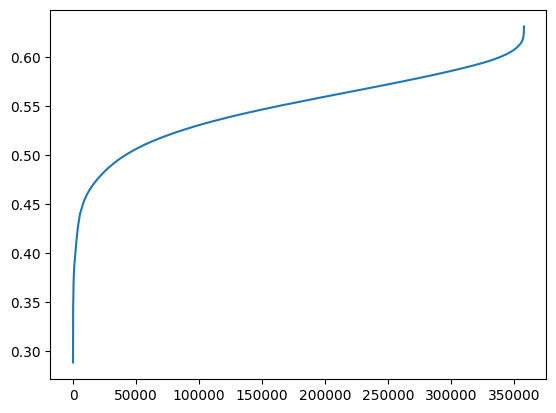

In [ ]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [ ]:
degree_threshold = 0.45

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

7828

In [ ]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,birth_year,weight,height,points,uci_points,length,climb_total,profile,startlist_quality,date,...,delta,race_year,raw_position,cyclist_bmi,climb_percentage,cyclist_climb_power,race_physical_effort,race_prestige,isolation_forest_degree,isolation_forest_scores
count,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828,...,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7.828000e+03,7828.000000,7828.000000,7828.000000,7828.0
mean,1983.266607,68.727976,179.948263,233.900102,411.461548,212.621963,3.368282,2.931783,1095.794584,2012-10-19 06:18:34.767501312,...,470.644737,2012.287174,59.408533,21.189667,0.083217,7.097627e-03,0.255625,0.420746,0.419122,1.0
min,1963.000000,48.000000,159.000000,20.000000,6.000000,1.900000,0.003000,1.000000,156.000000,2001-03-31 00:00:00,...,0.000000,2001.000000,0.000000,16.604275,0.000261,3.154450e-07,0.000003,0.000000,0.288389,1.0
25%,1976.000000,63.000000,175.000000,100.000000,120.000000,206.000000,2.089000,2.000000,891.000000,2005-10-15 00:00:00,...,14.000000,2005.000000,14.000000,20.147972,0.007992,1.966297e-05,0.055869,0.253017,0.402656,1.0
50%,1982.000000,68.000000,180.000000,275.000000,500.000000,256.000000,3.789000,2.000000,1088.000000,2012-05-26 00:00:00,...,205.000000,2012.000000,50.000000,21.107266,0.016518,9.934320e-05,0.192669,0.443524,0.426933,1.0
75%,1990.000000,74.000000,185.000000,350.000000,600.000000,262.200000,4.565000,5.000000,1307.000000,2019-09-15 00:00:00,...,654.000000,2019.000000,95.000000,22.094080,0.022858,2.581863e-03,0.384171,0.584334,0.441288,1.0
max,2004.000000,94.000000,204.000000,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,...,46380.000000,2023.000000,194.000000,26.775510,1.012105,1.000000e+00,0.895288,0.908128,0.449999,1.0
std,9.078935,7.349844,7.284417,111.064331,248.708610,90.352952,1.586129,1.557696,289.230421,NaN,...,941.329717,7.194930,49.373144,1.478101,0.210748,2.557100e-02,0.225781,0.239971,0.027167,0.0


In [ ]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/cyclists_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Races Dataset

<Axes: >

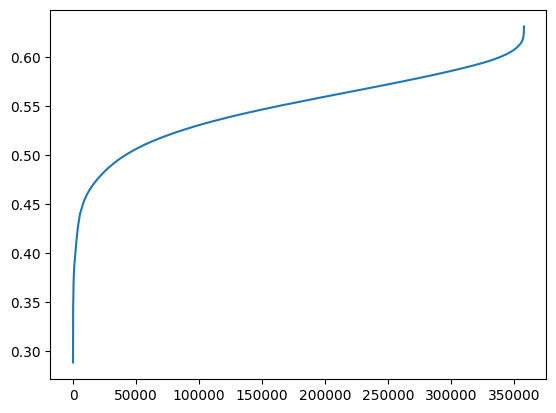

In [ ]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [ ]:
degree_threshold = 0.45

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

7828

In [ ]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,birth_year,weight,height,points,uci_points,length,climb_total,profile,startlist_quality,date,...,delta,race_year,raw_position,cyclist_bmi,climb_percentage,cyclist_climb_power,race_physical_effort,race_prestige,isolation_forest_degree,isolation_forest_scores
count,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828,...,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7.828000e+03,7828.000000,7828.000000,7828.000000,7828.0
mean,1983.266607,68.727976,179.948263,233.900102,411.461548,212.621963,3.368282,2.931783,1095.794584,2012-10-19 06:18:34.767501312,...,470.644737,2012.287174,59.408533,21.189667,0.083217,7.097627e-03,0.255625,0.420746,0.419122,1.0
min,1963.000000,48.000000,159.000000,20.000000,6.000000,1.900000,0.003000,1.000000,156.000000,2001-03-31 00:00:00,...,0.000000,2001.000000,0.000000,16.604275,0.000261,3.154450e-07,0.000003,0.000000,0.288389,1.0
25%,1976.000000,63.000000,175.000000,100.000000,120.000000,206.000000,2.089000,2.000000,891.000000,2005-10-15 00:00:00,...,14.000000,2005.000000,14.000000,20.147972,0.007992,1.966297e-05,0.055869,0.253017,0.402656,1.0
50%,1982.000000,68.000000,180.000000,275.000000,500.000000,256.000000,3.789000,2.000000,1088.000000,2012-05-26 00:00:00,...,205.000000,2012.000000,50.000000,21.107266,0.016518,9.934320e-05,0.192669,0.443524,0.426933,1.0
75%,1990.000000,74.000000,185.000000,350.000000,600.000000,262.200000,4.565000,5.000000,1307.000000,2019-09-15 00:00:00,...,654.000000,2019.000000,95.000000,22.094080,0.022858,2.581863e-03,0.384171,0.584334,0.441288,1.0
max,2004.000000,94.000000,204.000000,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,...,46380.000000,2023.000000,194.000000,26.775510,1.012105,1.000000e+00,0.895288,0.908128,0.449999,1.0
std,9.078935,7.349844,7.284417,111.064331,248.708610,90.352952,1.586129,1.557696,289.230421,NaN,...,941.329717,7.194930,49.373144,1.478101,0.210748,2.557100e-02,0.225781,0.239971,0.027167,0.0


In [ ]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/races_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Cyclist + Races Merged Dataset

<Axes: >

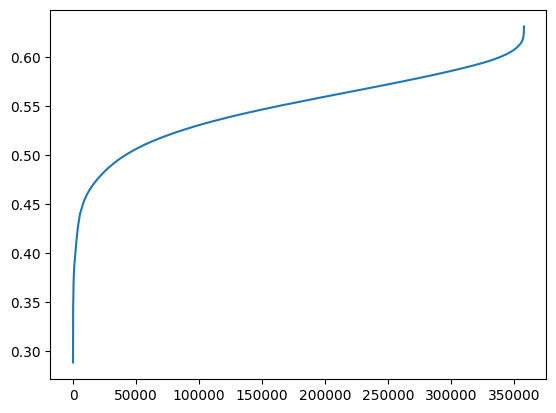

In [ ]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [ ]:
degree_threshold = 0.45

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

7828

In [ ]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,birth_year,weight,height,points,uci_points,length,climb_total,profile,startlist_quality,date,...,delta,race_year,raw_position,cyclist_bmi,climb_percentage,cyclist_climb_power,race_physical_effort,race_prestige,isolation_forest_degree,isolation_forest_scores
count,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828,...,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7.828000e+03,7828.000000,7828.000000,7828.000000,7828.0
mean,1983.266607,68.727976,179.948263,233.900102,411.461548,212.621963,3.368282,2.931783,1095.794584,2012-10-19 06:18:34.767501312,...,470.644737,2012.287174,59.408533,21.189667,0.083217,7.097627e-03,0.255625,0.420746,0.419122,1.0
min,1963.000000,48.000000,159.000000,20.000000,6.000000,1.900000,0.003000,1.000000,156.000000,2001-03-31 00:00:00,...,0.000000,2001.000000,0.000000,16.604275,0.000261,3.154450e-07,0.000003,0.000000,0.288389,1.0
25%,1976.000000,63.000000,175.000000,100.000000,120.000000,206.000000,2.089000,2.000000,891.000000,2005-10-15 00:00:00,...,14.000000,2005.000000,14.000000,20.147972,0.007992,1.966297e-05,0.055869,0.253017,0.402656,1.0
50%,1982.000000,68.000000,180.000000,275.000000,500.000000,256.000000,3.789000,2.000000,1088.000000,2012-05-26 00:00:00,...,205.000000,2012.000000,50.000000,21.107266,0.016518,9.934320e-05,0.192669,0.443524,0.426933,1.0
75%,1990.000000,74.000000,185.000000,350.000000,600.000000,262.200000,4.565000,5.000000,1307.000000,2019-09-15 00:00:00,...,654.000000,2019.000000,95.000000,22.094080,0.022858,2.581863e-03,0.384171,0.584334,0.441288,1.0
max,2004.000000,94.000000,204.000000,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,...,46380.000000,2023.000000,194.000000,26.775510,1.012105,1.000000e+00,0.895288,0.908128,0.449999,1.0
std,9.078935,7.349844,7.284417,111.064331,248.708610,90.352952,1.586129,1.557696,289.230421,NaN,...,941.329717,7.194930,49.373144,1.478101,0.210748,2.557100e-02,0.225781,0.239971,0.027167,0.0


In [ ]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/complete_dataset_no_outliers.csv', index=False)